In [1]:
import pyspedas
import pytplot

**Using cdf_to_tplot PYTPLOT Function**

In [2]:

#Using cdf_to_tplot

# cdf = pytplot.cdf_to_tplot(r"wget_download\wi_h1_swe_20031120_v01.cdf",notplot=True)
# cdf.keys()
# cdf['BX']['y']

**Using CDFLIB**

In [3]:
import cdflib
cdf_file = cdflib.CDF(r'wget_download\wi_h1_swe_20031120_v01.cdf')
# cdf_file.cdf_info()


In [4]:
t_range= cdflib.cdfepoch.to_datetime(cdf_file.varget('epoch'))
t_range[:10]

array(['2003-11-20T00:01:12.248000', '2003-11-20T00:02:49.401000',
       '2003-11-20T00:04:26.554000', '2003-11-20T00:06:03.707000',
       '2003-11-20T00:07:40.861000', '2003-11-20T00:09:18.014000',
       '2003-11-20T00:10:55.167000', '2003-11-20T00:12:32.320000',
       '2003-11-20T00:14:09.473000', '2003-11-20T00:15:46.626000'],
      dtype='datetime64[us]')

In [5]:

BX = cdf_file.varget('BX')
BY = cdf_file.varget('BY')
BZ = cdf_file.varget('BZ')

**TPLOT PLOTTING**

In [6]:
# pytplot.store_data("BX",data={'x':t_range,'y':BX})
# pytplot.store_data("BY",data={'x':t_range,'y':BY})
# pytplot.store_data("BZ",data={'x':t_range,'y':BZ})

# pytplot.options("BX",'color','red')
# pytplot.options("BY",'color','blue')
# pytplot.options("BZ",'color','green')
# pytplot.options("Bmag","ytitle",r'$B_{vec}$')

# pytplot.options("BX", 'legend_names', 'BX')
# pytplot.options("BY", 'legend_names', 'BY')
# pytplot.options("BZ", 'legend_names', 'BZ')

# pytplot.store_data("Bmag",['BX','BY','BZ'])
# # help(pytplot.tplot_options)

# pytplot.options('border','true')

# pytplot.tplot(['Bmag'])

**MATPLOTLIB**

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

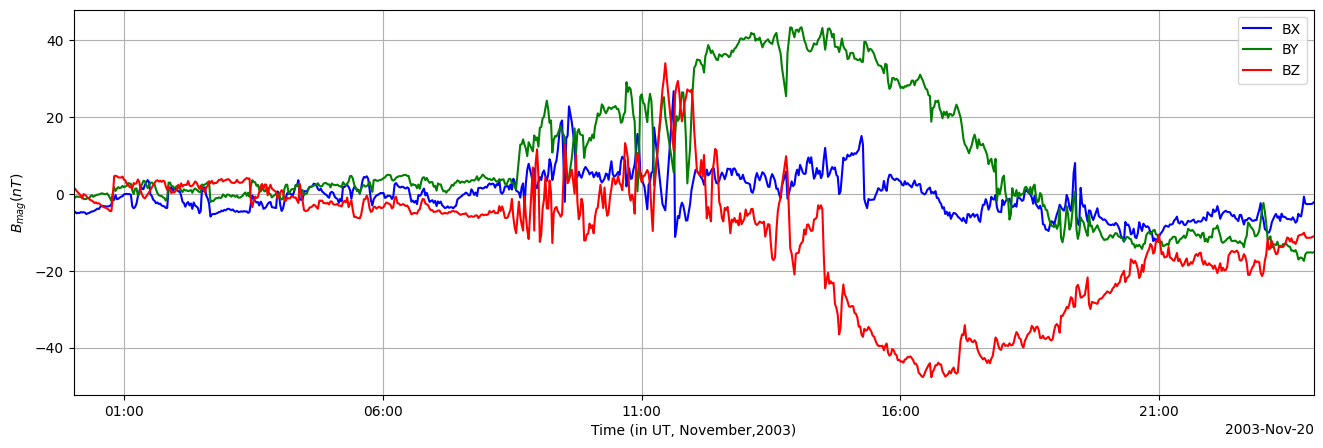

In [8]:
fig,ax = plt.subplots(1, 1,sharex=True, figsize=(16, 5))

# Set x-axis ticks to show intervals of 6 hours
hours = mdates.HourLocator(interval=5)
# h_fmt = mdates.DateFormatter('%d/%m/%y %H:%M')  # Hour and minute format

plt.gca().xaxis.set_major_locator(hours)
# plt.gca().xaxis.set_major_formatter(h_fmt)

plt.xlim(t_range[0], t_range[-1])

ax.set_xlabel('Time (in UT, November,2003)')
ax.set_ylabel(r'$B_{mag} (nT)$')
ax.tick_params(axis='x',)

ax.plot(t_range,BX,label ='BX',color='blue')
ax.plot(t_range,BY,label ='BY',color='green')
ax.plot(t_range,BZ,label ='BZ',color='red')
ax.legend(loc="upper right")
ax.grid(True)



In [9]:
cdf_file.varget('Proton_Wpar_moment')[:10]

array([61.765823, 76.84113 , 78.44904 , 69.18992 , 70.616486, 77.5695  ,
       73.83397 , 73.363464, 72.16269 , 64.73081 ], dtype=float32)

In [162]:
import requests
from bs4 import BeautifulSoup as bs
import wget

# response = requests.get('https://cdaweb.gsfc.nasa.gov/pub/data/wind/swe/swe_h1/2003/wi_h1_swe_20031120_v01.cdf')
url = 'https://cdaweb.gsfc.nasa.gov/pub/data/wind/swe/swe_h1/2003/wi_h1_swe_20031120_v01.cdf'

In [163]:
wget.download(url, 'wi_h1_swe_20031120_v01.cdf')

'wi_h1_swe_20031120_v01.cdf'

In [15]:
import cdflib
cdf_file2 = cdflib.CDF(r'wget_download\wi_h1_swe_20031120_v01.cdf')
# cdf_file2.cdf_info()

In [16]:
BX2 = cdf_file2.varget('BX')

In [17]:
BX2[:10]

array([-4.5006084, -4.6028657, -5.002913 , -4.858102 , -4.9570494,
       -4.699966 , -4.7766275, -4.7127743, -4.8075223, -5.218494 ],
      dtype=float32)